{/* cspell:ignore setminus coloneqq rbrack  // latex that isn't being ignored for some reason */}

# Pauli Correlation Encoding to reduce Maxcut requirements

*Usage estimate: 30 minutes on IBM Sherbrooke (NOTE: This is an estimate only. Your runtime may vary.)*

## Background
This notebook presents *Pauli Correlation Encoding* (PCE) [\[1\]](#references), an approach designed to encode optimization problems into qubits with greater efficiency for quantum computation. PCE maps classical variables in optimization problems to multi-body Pauli-matrix correlations, resulting in a polynomial compression of the problem's space requirements. By employing PCE, the number of qubits needed for encoding is reduced, making it particularly advantageous for near-term quantum devices with limited qubit resources. Furthermore, it is analytically demonstrated that PCE inherently mitigates barren plateaus, offering super-polynomial resilience against this phenomenon. This built-in feature enables unprecedented performance in quantum optimization solvers.

### Overview
The PCE approach consists of three main steps, as illustrated in the Figure 1 from [\[1\]](#references) in below:
1. Encoding the optimization problem into a Pauli correlation space.
2. Solving the problem using a quantum-classical optimization solver.
3. Decoding the solution back to the original optimization space.
The PCE approach is adaptable to any quantum optimization solver capable of processing Pauli correlation matrices.

![pce-overview.png](/docs/images/tutorials/solving-maxcut-with-reduced-qubit-requirements-using-pauli-correlation-encoding/af2cb835-88db-4a3d-9c86-51424b1a4bd3.avif)

in the Figure 1 from [\[1\]](#references) , Max-Cut problem is used as an example to illustrate the PCE approach. The Max-Cut problem with $m=9$ nodes is encoded into a Pauli correlation space, representing the optimization problem as a correlation matrix, specifically, 2-body Pauli-matrix correlations across $n=3$ qubits $(Q_1, Q_2, Q_3)$. Node colors indicate the Pauli string used for each encoded node.
For example, that node 1, which corresponds to binary variable $x_1$, is encoded by the expectation value of $Z_1 \otimes Z_2 \otimes I_3$, while $x_8$ is encoded by $I_1 \otimes Y_2 \otimes Y_3$.
This corresponds to compressing the problem’s $m$ variables into $ n = O(m^{1/2})$ qubits. More broadly, $k $-body correlations enable polynomial compressions of order $k$. The chosen Pauli set comprises three subsets of mutually-commuting Pauli strings, allowing all $m$ correlations to be experimentally estimated with only three measurement settings.

A loss function $\mathcal{L}$ of Pauli expectation values that imitates the original Max-Cut objective function is constructed. The loss function is then optimized using a quantum-classical optimization solver, such as the  Variational Quantum Eigensolver (VQE).

Once the optimization is complete, the solution is decoded back to the original optimization space, yielding the optimal Max-Cut solution.

## Requirements

Before starting this tutorial, be sure you have the following installed:
- Qiskit SDK v1.0 or later, with visualization support ( `pip install 'qiskit[visualization]'` )
- Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
- Rustworkx graph library (`pip install rustworkx`)

## Setup

In [8]:
from itertools import combinations

import numpy as np
import rustworkx as rx
from scipy.optimize import minimize

from qiskit.circuit.library import efficient_su2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session
from rustworkx.visualization import mpl_draw

service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)

In [9]:
def calc_cut_size(graph, partition0, partition1):
    """Calculate the cut size of the given partitions of the graph."""

    cut_size = 0
    for edge0, edge1 in graph.edge_list():
        if edge0 in partition0 and edge1 in partition1:
            cut_size += 1
        elif edge0 in partition1 and edge1 in partition0:
            cut_size += 1
    return cut_size

## Step 1: Map classical inputs to a quantum problem

### Max-Cut Problem
The Max-Cut problem is a combinatorial optimization problem that is defined on a graph $G = (V, E)$, where $V$ is the set of vertices and $E$ is the set of edges. The goal is to partition the vertices into two sets, $S$ and $V \setminus S$, such that the number of edges between the two sets is maximized.
For the detailed description of the Max-Cut problem, please refer to the ["Solve utility-scale quantum optimization problems"](https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm) tutorial.
Also, the Max-Cut problem is used as an example in the tutorial ["Advanced Techniques for QAOA"](https://learning.quantum.ibm.com/tutorial/advanced-techniques-for-qaoa).
In those tutorials, the QAOA algorithm is used to solve the Max-Cut problem.


### Graph -> Hamiltonian
In this tutorial, we will use a random graph with 1000 nodes.

The problem size might be hard to visualize, so below is a graph with 100 nodes. (Rendering a graph with 1,000 nodes directly would make it too dense to see anything!) The graph we are working with is ten times larger.

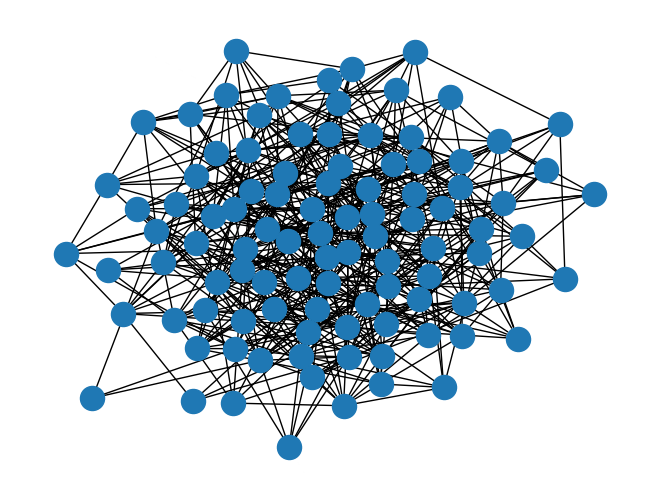

In [10]:
mpl_draw(rx.undirected_gnp_random_graph(100, 0.1, seed=42))

In [11]:
num_nodes = 1000  # Number of nodes in graph
graph = rx.undirected_gnp_random_graph(num_nodes, 0.1, seed=42)

In [12]:
import networkx as nx

nx_graph = nx.Graph()
nx_graph.add_nodes_from(range(num_nodes))

In [13]:
for edge in graph.edge_list():
    nx_graph.add_edge(edge[0], edge[1])

In [14]:
curr_cut_size, partition = nx.approximation.one_exchange(nx_graph, seed=1)
print(f"Initial cut size: {curr_cut_size}")

Initial cut size: 28075


We encode the graph with 1000 nodes into 2-body Pauli-matrix correlations across 100 qubits. The graph is represented as a correlation matrix, where each node is encoded by a Pauli string. The sign of the expectation value of the Pauli string indicates the partition of the node. For example, node 0 is encoded by a Pauli string, $\prod_0 = I_{19} \otimes ... I_2 \otimes X_1 \otimes X_0$. The sign of the expectation value of this Pauli string indicates the partition of node 0. We define a *Pauli-correlation encoding* (PCE) relative to $\prod$ as

$ x_i \coloneqq \textit{sgn}(\langle\prod_i \rangle) $

where $x_i$ is the partition of node $i$ and $\langle \prod_i \rangle \coloneqq  \langle \psi |\prod_i| \psi \rangle $ is the expectation value of the Pauli string encoding node $i$ over a quantum state $|\psi \rangle$.

Now, let's encode the graph into a Hamiltonian using PCE.
We divide the nodes into three sets: $S_1$, $S_2$, and $S_3$.
Then, we encode the nodes in each set using the Pauli strings with $X$, $Y$, and $Z$, respectively.

In [6]:
num_qubits = 100

list_size = num_nodes // 3
node_x = [i for i in range(list_size)]
node_y = [i for i in range(list_size, 2 * list_size)]
node_z = [i for i in range(2 * list_size, num_nodes)]

print("List 1:", node_x)
print("List 2:", node_y)
print("List 3:", node_z)

List 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [7]:
def build_pauli_correlation_encoding(pauli, node_list, n, k=2):
    pauli_correlation_encoding = []
    for idx, c in enumerate(combinations(range(n), k)):
        if idx >= len(node_list):
            break
        paulis = ["I"] * n
        paulis[c[0]], paulis[c[1]] = pauli, pauli
        pauli_correlation_encoding.append(("".join(paulis)[::-1], 1))

    hamiltonian = []
    for pauli, weight in pauli_correlation_encoding:
        hamiltonian.append(SparsePauliOp.from_list([(pauli, weight)]))

    return hamiltonian


pauli_correlation_encoding_x = build_pauli_correlation_encoding(
    "X", node_x, num_qubits
)
pauli_correlation_encoding_y = build_pauli_correlation_encoding(
    "Y", node_y, num_qubits
)
pauli_correlation_encoding_z = build_pauli_correlation_encoding(
    "Z", node_z, num_qubits
)

## Step 2: Optimize problem for quantum hardware execution

### Quantum circuit
Here, the state $|\psi \rangle$ is parameterized with $\mathbf{\theta}$, and we optimize these parameters $\mathbf{\theta}$ using a variational approach.
In this tutorial, we employ the `efficient_su2` ansatz for our variational algorithm due to its expressive capabilities and ease of implementation.
We also use the relaxed loss function, which will be introduced later in this tutorial.
As a result, we can address large-scale problems with fewer qubits and shallower circuit depths.

In [8]:
# Build the quantum circuit
qc = efficient_su2(num_qubits, ["ry", "rz"], reps=2)

In [12]:
# Optimize the circuit

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
qc = pm.run(qc)

### Loss function
For the loss function $\mathcal{L}$, we use a relaxation of the Max-Cut objective function as described in [\[1\]](#references), which is defined as $\mathcal{V}(\mathbf{x}) \coloneqq \sum_{(i, j) \in E} W_{i, j}(1-x_i x_j)$. Here, $W_{i, j}$ denotes the weight of the edge $(i, j)$, and $x_i$ represents the partition of node $i$.
The loss function  $\mathcal{L}$ is given by:

$\mathcal{L}\coloneqq \sum_{(i, j) \in E} W_{i, j} \text{tanh} (\alpha \langle\prod_i \rangle) \text{tanh} (\alpha \langle\prod_j \rangle) + \mathcal{L}^{(\text{reg})}$

where the Max-Cut objective function is replaced by the smooth hyperbolic tangents of the expectation values of the Pauli strings encoding the nodes. The regularization term $\mathcal{L}^{(\text{reg})}$ and the rescaling factor $\alpha$, proportional to the number of qubits, are introduced to improve the solver's performance.

The regularization term is defined as:

$\mathcal{L}^{(\text{reg})}$ is defined as $\mathcal{L}^{(\text{reg})} \coloneqq \beta \nu \lbrack \frac{1}{m} \sum_{i \in V} \text{tanh} (\alpha \langle\prod_i \rangle)^2 \rbrack ^2$

where $\beta=1/2$, $\nu = |E|/2 + (m -1) /4$, and $m$ is the number of nodes in the graph.

In [13]:
def loss_func_estimator(x, ansatz, hamiltonian, estimator, graph):
    """
    Calculates the specified loss function for the given ansatz, Hamiltonian, and graph.

    The expectation values of each Pauli string in the Hamiltonian are first obtained
    by running the ansatz on the quantum backend. These expectation values are then
    passed through the nonlinear function tanh(alpha * prod_i). The loss function is
    subsequently computed from these transformed values.
    """
    job = estimator.run(
        [
            (ansatz, hamiltonian[0], x),
            (ansatz, hamiltonian[1], x),
            (ansatz, hamiltonian[2], x),
        ]
    )
    result = job.result()

    # calculate the loss function
    node_exp_map = {}
    idx = 0
    for r in result:
        for ev in r.data.evs:
            node_exp_map[idx] = ev
            idx += 1

    loss = 0
    alpha = num_qubits
    for edge0, edge1 in graph.edge_list():
        loss += np.tanh(alpha * node_exp_map[edge0]) * np.tanh(
            alpha * node_exp_map[edge1]
        )

    regulation_term = 0
    for i in range(len(graph.nodes())):
        regulation_term += np.tanh(alpha * node_exp_map[i]) ** 2
    regulation_term = regulation_term / len(graph.nodes())
    regulation_term = regulation_term**2
    beta = 1 / 2
    v = len(graph.edges()) / 2 + (len(graph.nodes()) - 1) / 4
    regulation_term = beta * v * regulation_term

    loss = loss + regulation_term

    global experiment_result
    print(f"Iter {len(experiment_result)}: {loss}")
    experiment_result.append({"loss": loss, "exp_map": node_exp_map})
    return loss

## Step 3: Execute using Qiskit primitives

In this tutorial, we set `max_iter=50` for the optimization loop for demonstration purpose. If we increase the number of iterations, we can expect better results.

In [13]:
pce = []
pce.append(
    [op.apply_layout(qc.layout) for op in pauli_correlation_encoding_x]
)
pce.append(
    [op.apply_layout(qc.layout) for op in pauli_correlation_encoding_y]
)
pce.append(
    [op.apply_layout(qc.layout) for op in pauli_correlation_encoding_z]
)

In [14]:
# Run the optimization using Session

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)

    experiment_result = []

    def loss_func(x):
        return loss_func_estimator(
            x, qc, [pce[0], pce[1], pce[2]], estimator, graph
        )

    np.random.seed(42)
    initial_params = np.random.rand(qc.num_parameters)
    result = minimize(
        loss_func, initial_params, method="COBYLA", options={"maxiter": 50}
    )
print(result)

Iter 0: 16659.649201600296
Iter 1: 12104.242957555361
Iter 2: 6541.137221994661
Iter 3: 6650.6188244671985
Iter 4: 7033.193518185085
Iter 5: 6743.687931793412
Iter 6: 6223.574718684094
Iter 7: 6457.3302709535965
Iter 8: 6581.316449107595
Iter 9: 6365.761052029896
Iter 10: 6415.872673527322
Iter 11: 6421.996561600348
Iter 12: 6636.372822791712
Iter 13: 6965.174320702346
Iter 14: 6774.236562696287
Iter 15: 6393.837617108355
Iter 16: 6234.311401676519
Iter 17: 6518.192237615901
Iter 18: 6559.933925068997
Iter 19: 6646.157979243488
Iter 20: 6573.726111605048
Iter 21: 6190.642092901959
Iter 22: 6653.06500163594
Iter 23: 6545.713700369988
Iter 24: 6399.996441760465
Iter 25: 6115.959687941808
Iter 26: 6665.915093554849
Iter 27: 6832.882201259893
Iter 28: 6541.392749578919
Iter 29: 6813.3456910443165
Iter 30: 6460.800944368402
Iter 31: 6359.635437029245
Iter 32: 6040.891641882451
Iter 33: 6573.930674936448
Iter 34: 6668.031753293785
Iter 35: 6450.002712889748
Iter 36: 6519.8298811058075
Iter 3

## Step 4: Post-process and return result in desired classical format

The partitions of the nodes are determined by evaluating the sign of the expectation values of the Pauli strings that encode the nodes.

In [15]:
# Calculate the partitions based on the final expectation values
# If the expectation value is positive, the node belongs to partition 0 (par0)
# Otherwise, the node belongs to partition 1 (par1)

par0, par1 = set(), set()

for i in experiment_result[-1]["exp_map"]:
    if experiment_result[-1]["exp_map"][i] >= 0:
        par0.add(i)
    else:
        par1.add(i)
print(par0, par1)

{0, 1, 4, 8, 9, 10, 12, 13, 14, 15, 16, 18, 25, 27, 31, 32, 34, 36, 38, 39, 40, 41, 44, 46, 47, 48, 49, 50, 51, 52, 57, 60, 61, 62, 63, 64, 65, 66, 68, 71, 79, 81, 82, 86, 88, 91, 92, 93, 94, 95, 96, 99, 100, 105, 106, 107, 112, 114, 115, 121, 123, 129, 133, 134, 145, 147, 161, 165, 166, 168, 171, 173, 184, 185, 187, 188, 192, 193, 194, 196, 197, 198, 202, 205, 206, 207, 208, 209, 210, 211, 215, 217, 218, 219, 220, 221, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 241, 242, 243, 244, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259, 261, 262, 264, 265, 266, 268, 269, 270, 272, 273, 275, 276, 277, 278, 279, 281, 283, 284, 285, 286, 288, 292, 293, 294, 299, 300, 303, 305, 306, 307, 308, 310, 312, 313, 314, 316, 317, 319, 321, 326, 327, 328, 333, 336, 338, 340, 341, 342, 344, 345, 346, 349, 351, 352, 353, 356, 357, 360, 361, 362, 363, 364, 366, 368, 370, 374, 378, 379, 380, 381, 382, 383, 384, 386, 387, 388, 389, 390, 391, 393, 394, 395, 396, 397, 398, 404, 4

We can calculate the cut size of the Max-Cut problem using the partitions of the node.

In [16]:
cut_size = calc_cut_size(graph, par0, par1)
print(f"Cut size: {cut_size}")

Cut size: 24682


Once the training is complete, we perform one round of single-bit swap search to improve the solution as a classical post-processing step.
In this process, we swap the partitions of two nodes and evaluate the cut size. If the cut size is improved, we keep the swap. We repeat this process for all possible pairs of nodes connected by an edge.

In [17]:
best_bits = []
cur_bits = []

for i in experiment_result[-1]["exp_map"]:
    if experiment_result[-1]["exp_map"][i] >= 0:
        cur_bits.append(1)
    else:
        cur_bits.append(0)
print(cur_bits)

[1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 

In [18]:
# Swap the partitions and calculate the cut size
best_cut = 0
for edge0, edge1 in graph.edge_list():
    swapped_bits = cur_bits.copy()
    swapped_bits[edge0], swapped_bits[edge1] = (
        swapped_bits[edge1],
        swapped_bits[edge0],
    )

    cur_partition = [set(), set()]
    for i, bit in enumerate(swapped_bits):
        if bit > 0:
            cur_partition[0].add(i)
        else:
            cur_partition[1].add(i)
    cut_size = calc_cut_size(graph, cur_partition[0], cur_partition[1])
    if best_cut < cut_size:
        best_cut = cut_size
        best_bits = swapped_bits

print(best_cut, best_bits)

24733 [1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 

## References

[1] Sciorilli, M., Borges, L., Patti, T. L., García-Martín, D., Camilo, G., Anandkumar, A., & Aolita, L. (2024). Towards large-scale quantum optimization solvers with few qubits. arXiv preprint arXiv:2401.09421.

## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_8ANZAlsKSFf6DA2)